## Overview

Perform some analysis of IBD, specifically:

- Plot summaries of IBD data (total IBD, no. tracts), comparing within and between sampling sites.

- Perhaps a network?

In [1]:
%run setup.ipynb

In [2]:
import popgen

In [3]:
# setup analysis (see analysis_config.ipynb for configuration)
analysis = popgen.analysis.PopulationAnalysis('../data/analysis')
analysis

<PopulationAnalysis at '../data/analysis'>

In [4]:
# plotting setup
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
sns.set_context('paper')
plt.rcParams['figure.dpi'] = 120
%config InlineBackend.figure_formats = {'retina', 'png'}

In [5]:
import pandas as pd

In [6]:
colnames = ("sample1", "id1", "sample2", "id2", 
            "chrom", "start", "stop", "LOD")

fstem = "../data/ag1000g_region_KES_{chrom}_free.ibd"

ibd_tab = pd.concat(
    [pd.read_table(fstem.format(chrom=chrom), 
                   header=None,
                   names=colnames) for chrom in ["3L", "3R"]])

In [7]:
ibd_tab["ibd_chunk_size"] = ibd_tab.stop - ibd_tab.start

In [8]:
ibd_tab.chrom.value_counts()

3R    3725
3L    3026
Name: chrom, dtype: int64

In [9]:
ibd_tab.LOD.describe()

count    6751.000000
mean       11.665184
std        19.910325
min         3.000000
25%         3.860000
50%         5.640000
75%        11.450000
max       531.090000
Name: LOD, dtype: float64

## Distribution of IBD LOD scores

Consider applying minimum? 3.0 currently.

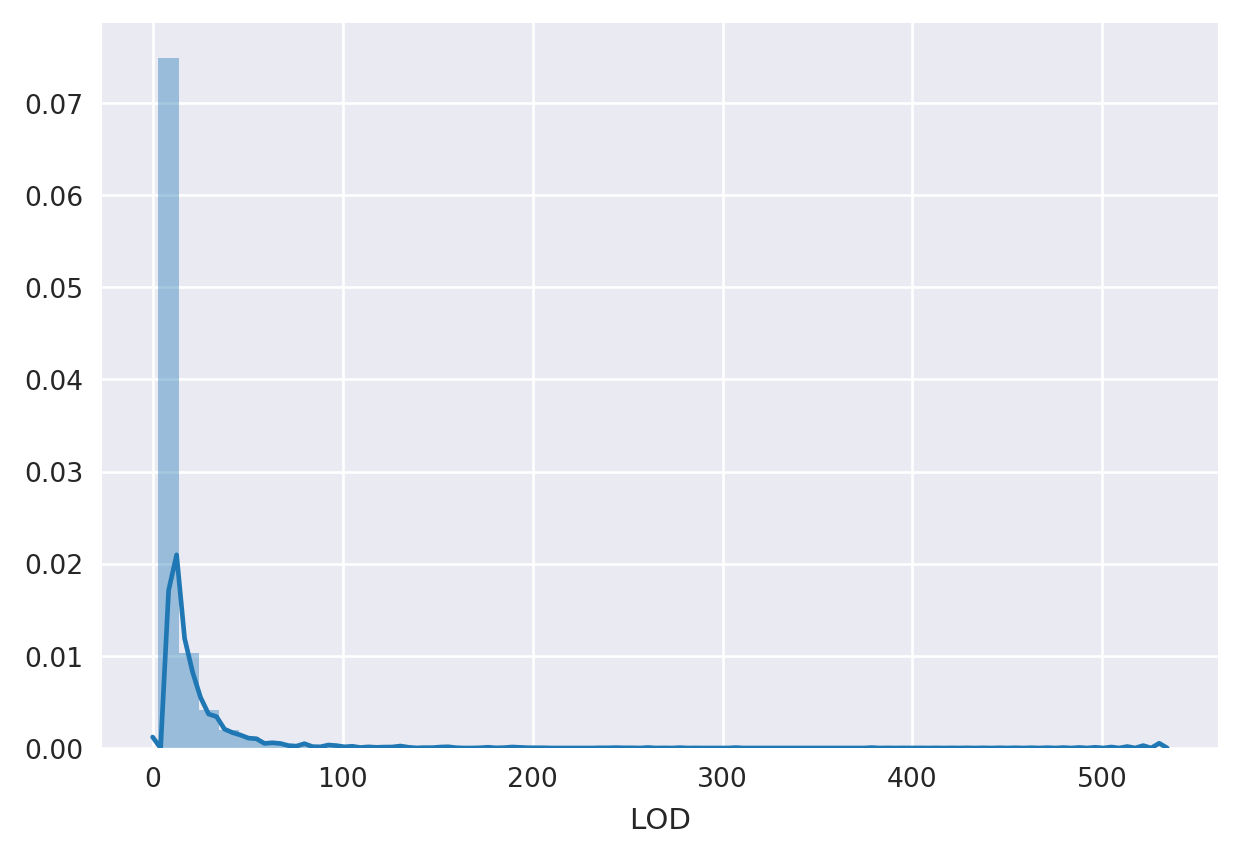

In [10]:
sns.distplot(ibd_tab.LOD)

## Distribution of IBD chunk sizes

Consider applying minimum?

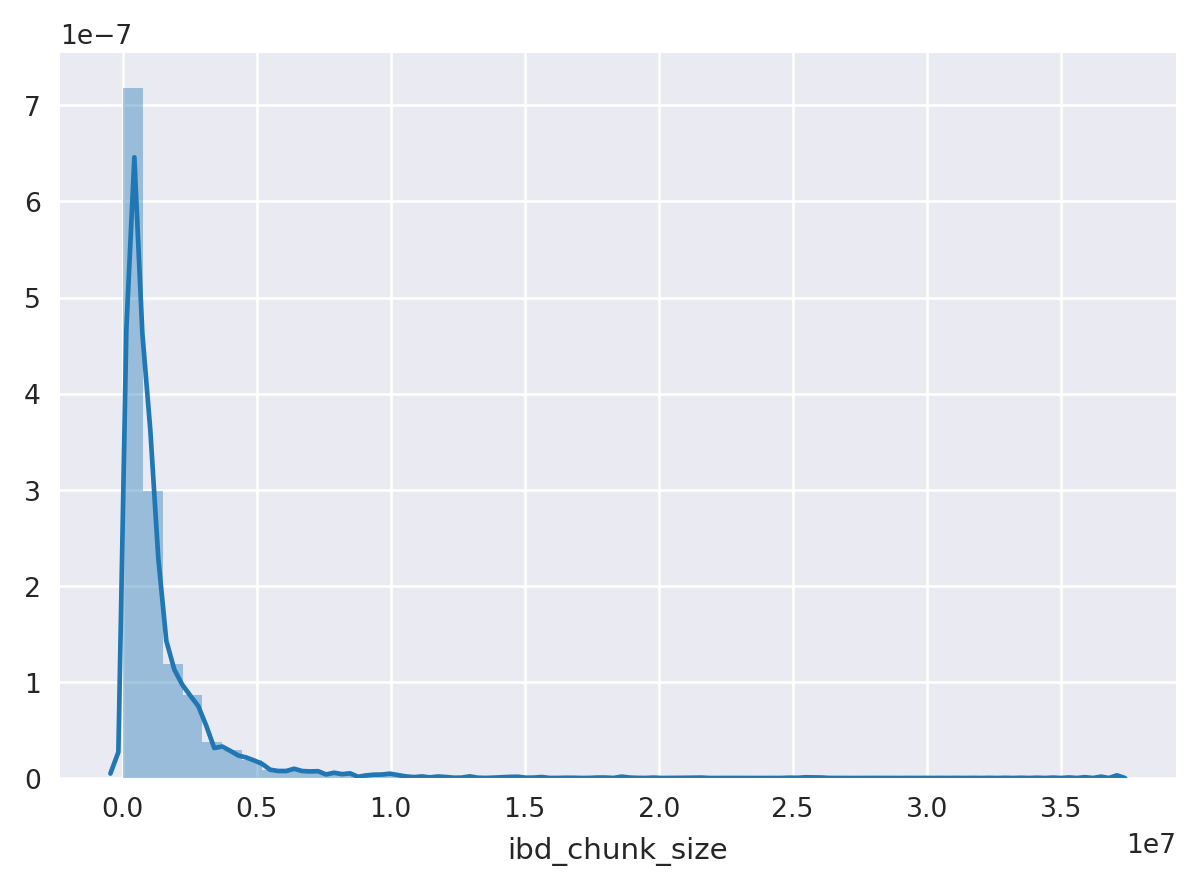

In [11]:
sns.distplot(ibd_tab.ibd_chunk_size)

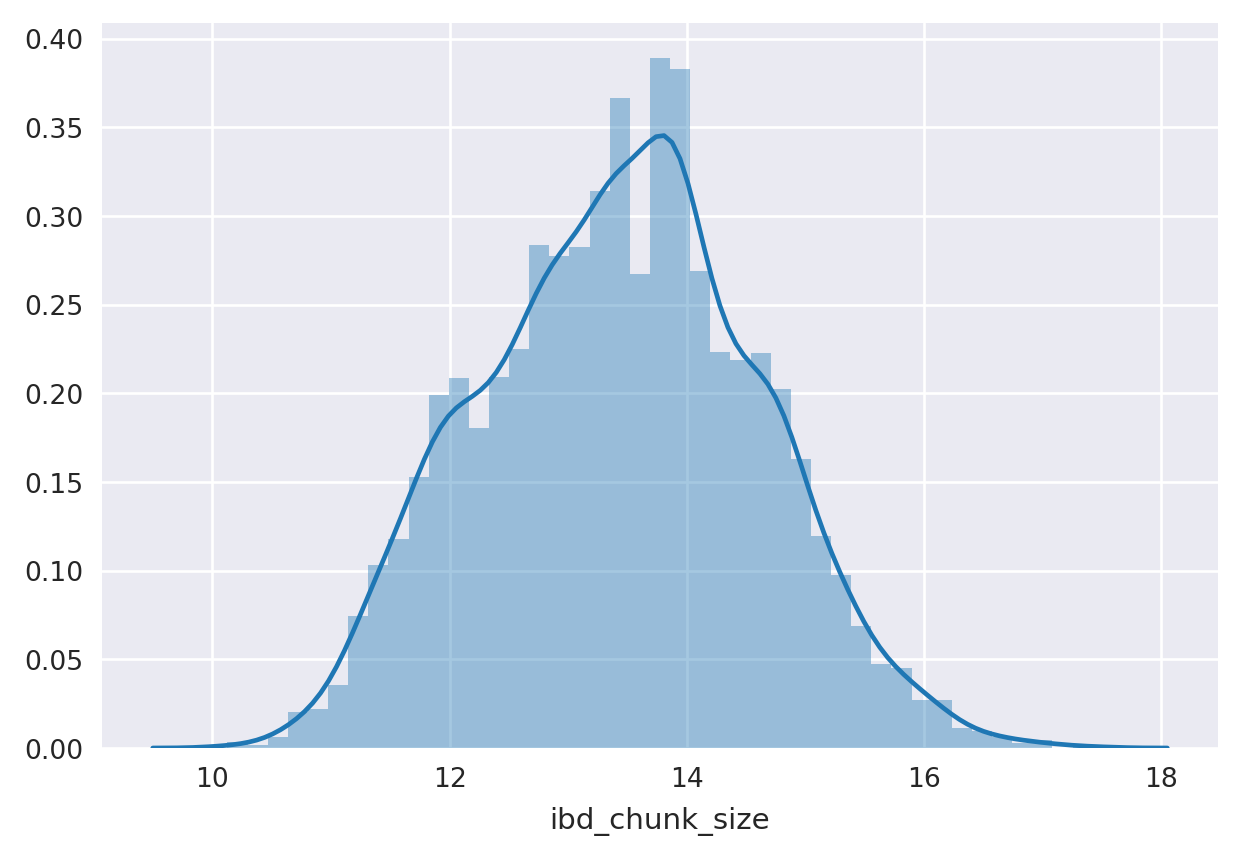

In [12]:
# log scale!
ax = sns.distplot(np.log(ibd_tab.ibd_chunk_size))

In [13]:
import pandas as pd

In [14]:
pops = analysis.config.get_populations()

In [15]:
# make a dict of sample to pop.
sample_sets = {x: set(analysis.get_population_samples(x)) 
     for x in pops.keys()}

In [16]:
def within_between(samples):
    
    s1, s2 = samples
    # 3 groups. within A, within B, between.
    indicator = 0
    indicator += (s1 in sample_sets["junju"])
    indicator += (s2 in sample_sets["junju"])
    
    indicatorB = 2
    indicatorB -= (s1 in sample_sets["mbogolo"])
    indicatorB -= (s2 in sample_sets["mbogolo"])
    
    assert indicator == indicatorB, (indicator, indicatorB, s1, s2)
    
    return indicator

In [17]:
r0 = ibd_tab.iloc[0]

ibd_tab["site"] = pd.Categorical.from_codes(
    ibd_tab[["sample1", "sample2"]].apply(within_between, 1),
    ["within_junju", "between", "within_mbogolo"])

## Naive plot of IBD chunk size distribution

Note- this only plots chunks _observed_.

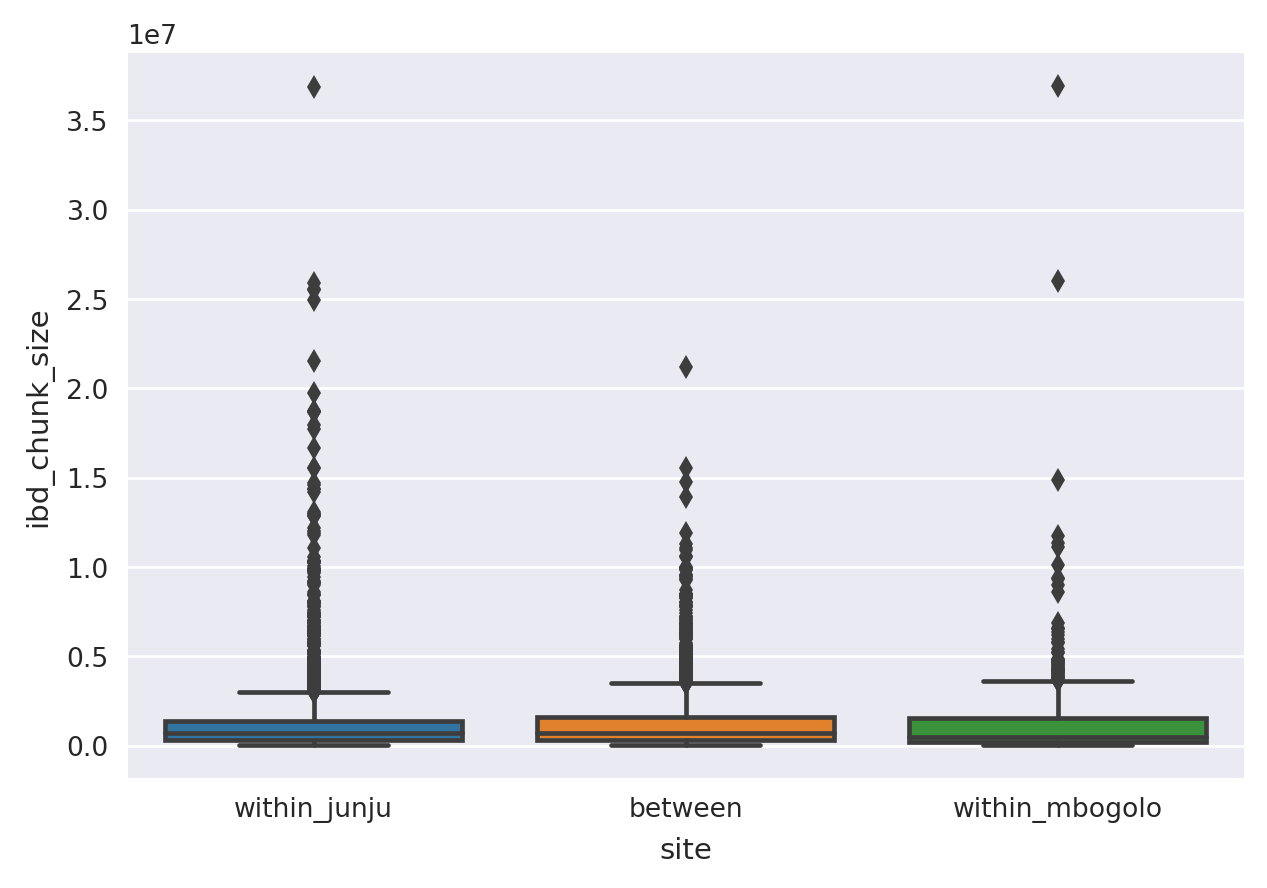

In [18]:
sns.boxplot(x="site", y="ibd_chunk_size", data=ibd_tab)

## Produce table of _all possible_ IBD pairings

In [19]:
from itertools import combinations

In [20]:
all_samples = analysis.get_population_samples("junju") + \
  analysis.get_population_samples("mbogolo")

In [21]:
palette = {x["label"]: x["color"] for p, x in pops.items()}
palette["Between"] = "grey"
palette

{'Between': 'grey', 'Kilifi-Junju': '#ff7f0e', 'Kilifi-Mbogolo': '#2ca02c'}

In [22]:
t = tuple(combinations(all_samples, 2))

In [23]:
all_pairs_ibd = pd.DataFrame(index=pd.MultiIndex.from_tuples(t),
                             columns=["IBDsum", "IBDcount", "site"],
                             dtype="int32")

In [24]:
# group the original data to look up by pair.
# We know that order ensures (A, B), never (B, A)
g = ibd_tab.groupby(["sample1", "sample2"])

In [25]:
for q in t:
    
    state = within_between(q)
    
    try:
        ibdsum, ibdc = g.get_group(q).ibd_chunk_size.aggregate(
            [np.sum, len])
    except KeyError:
        ibdsum, ibdc = 0, 0
        
    all_pairs_ibd.loc[q] = ibdsum, ibdc, state

In [26]:
pops

{'junju': {'color': '#ff7f0e',
  'description': None,
  'down_sample': None,
  'label': 'Kilifi-Junju',
  'marker': 'o',
  'query': 'country == "Kenya" and region == "Kilifi-Junju"',
  'random_seed': 0},
 'mbogolo': {'color': '#2ca02c',
  'description': None,
  'down_sample': None,
  'label': 'Kilifi-Mbogolo',
  'marker': 'o',
  'query': 'country == "Kenya" and region == "Kilifi-Mbogolo"',
  'random_seed': 0}}

In [27]:
all_pairs_ibd["site"] = pd.Categorical.from_codes(
    all_pairs_ibd["site"], 
    ["Kilifi-Junju", "Between", "Kilifi-Mbogolo"])

## Statistical tests

In [28]:
from scipy.stats import mannwhitneyu

In [29]:
rholder = []
result = r"{a} vs {b}. U={stat}. P-value={pv:.2e}"

for (a, b) in combinations(all_pairs_ibd.site.unique(), 2):
    
    xval = all_pairs_ibd.query("site == @a").IBDsum
    yval = all_pairs_ibd.query("site == @b").IBDsum

    x = mannwhitneyu(x=xval, y=yval)
    
    if x.pvalue < 0.001:
        q = "$^{**}$"
    elif x.pvalue < 0.01:
        q = "$^{*}$"
    else:
        q = ""
        
    rholder.append(result.format(a=a, b=b, stat=x.statistic,
                                 pv=x.pvalue)+q)

In [30]:
rholder

['Kilifi-Mbogolo vs Between. U=1429.0. P-value=2.58e-64$^{**}$',
 'Kilifi-Mbogolo vs Kilifi-Junju. U=16684.0. P-value=1.29e-01',
 'Between vs Kilifi-Junju. U=9504.0. P-value=4.87e-125$^{**}$']

## Plots

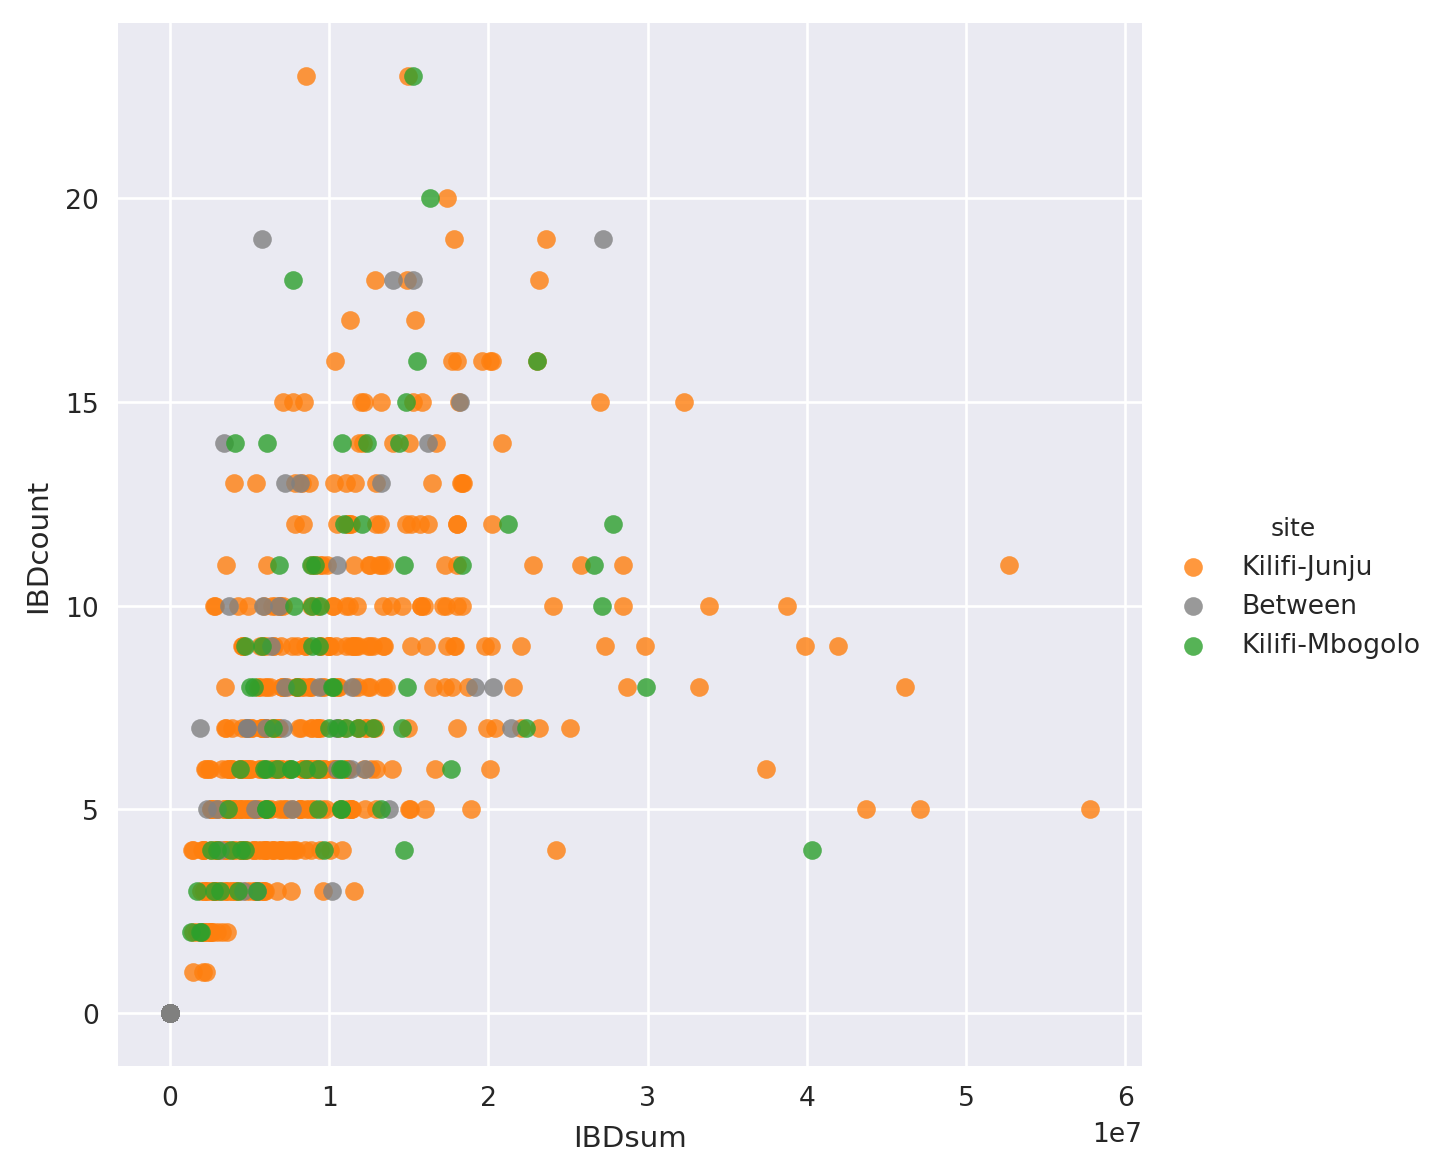

In [31]:
sns.lmplot(x="IBDsum", y="IBDcount", 
           data=all_pairs_ibd, 
           palette=palette,
           hue="site", 
           fit_reg=False)

(0.0, 60686422.649999999)

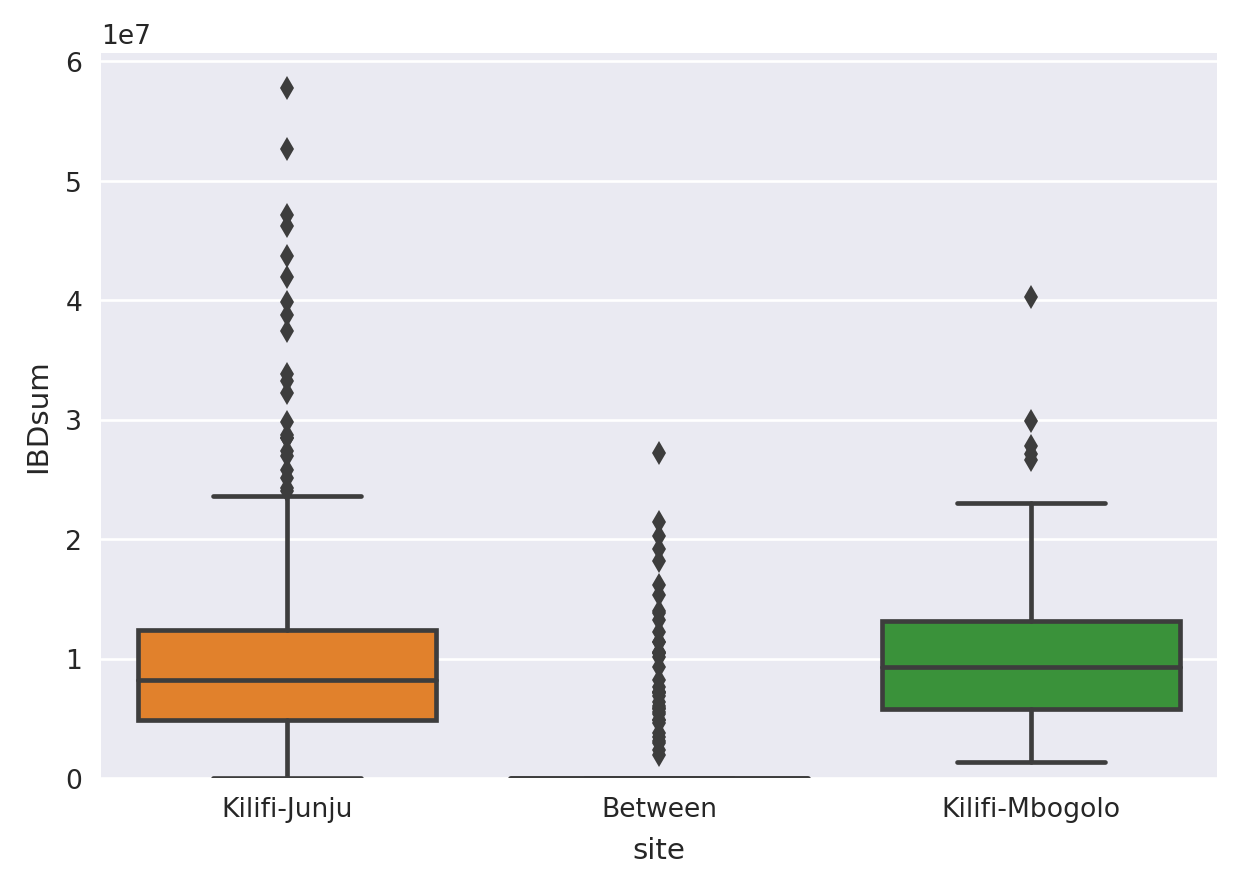

In [32]:
ax = sns.boxplot(x="site", y="IBDsum", 
                 data=all_pairs_ibd, palette=palette)
ax.set_ylim(bottom=0.0)

(0.0, 24.149999999999999)

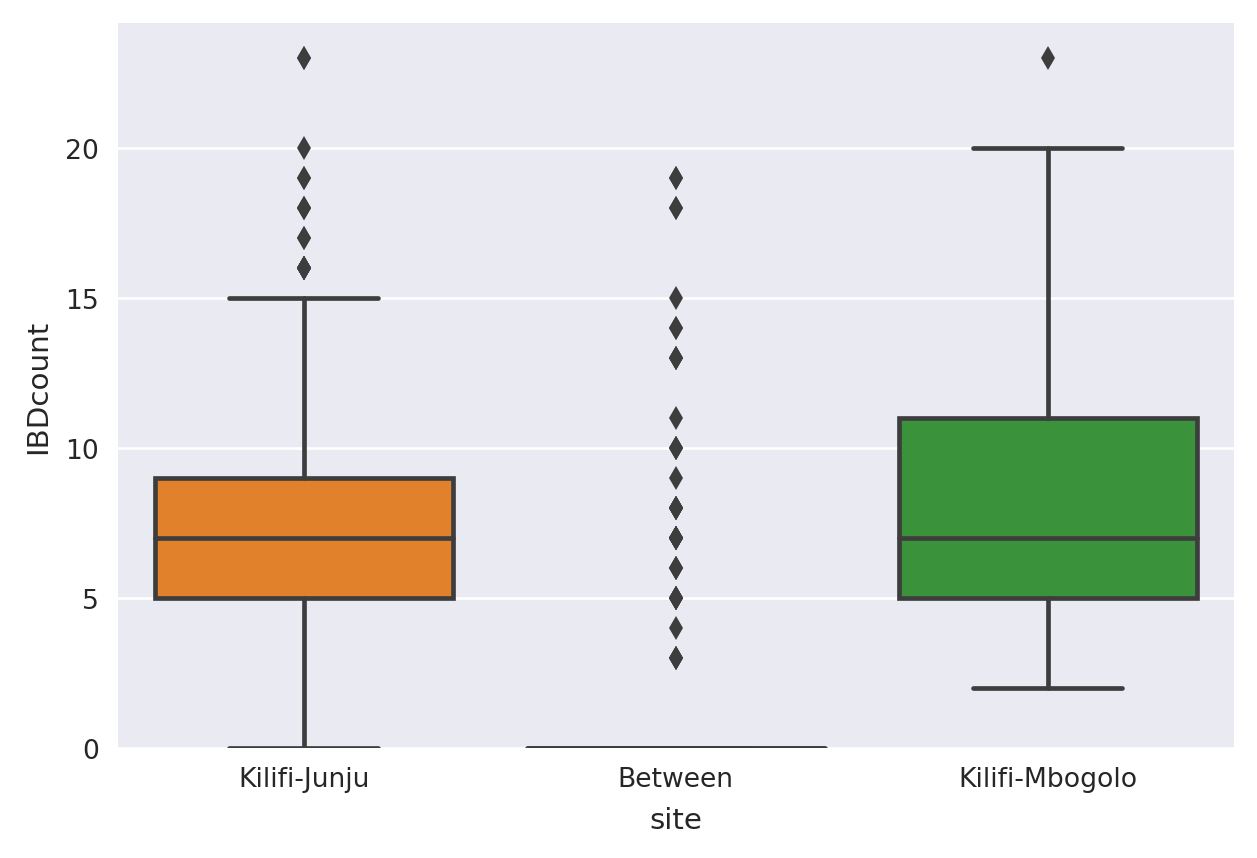

In [33]:
ax = sns.boxplot(x="site", y="IBDcount", 
                 palette=palette,
                 data=all_pairs_ibd)
ax.set_ylim(bottom=0.0)

## Alternate data presentation

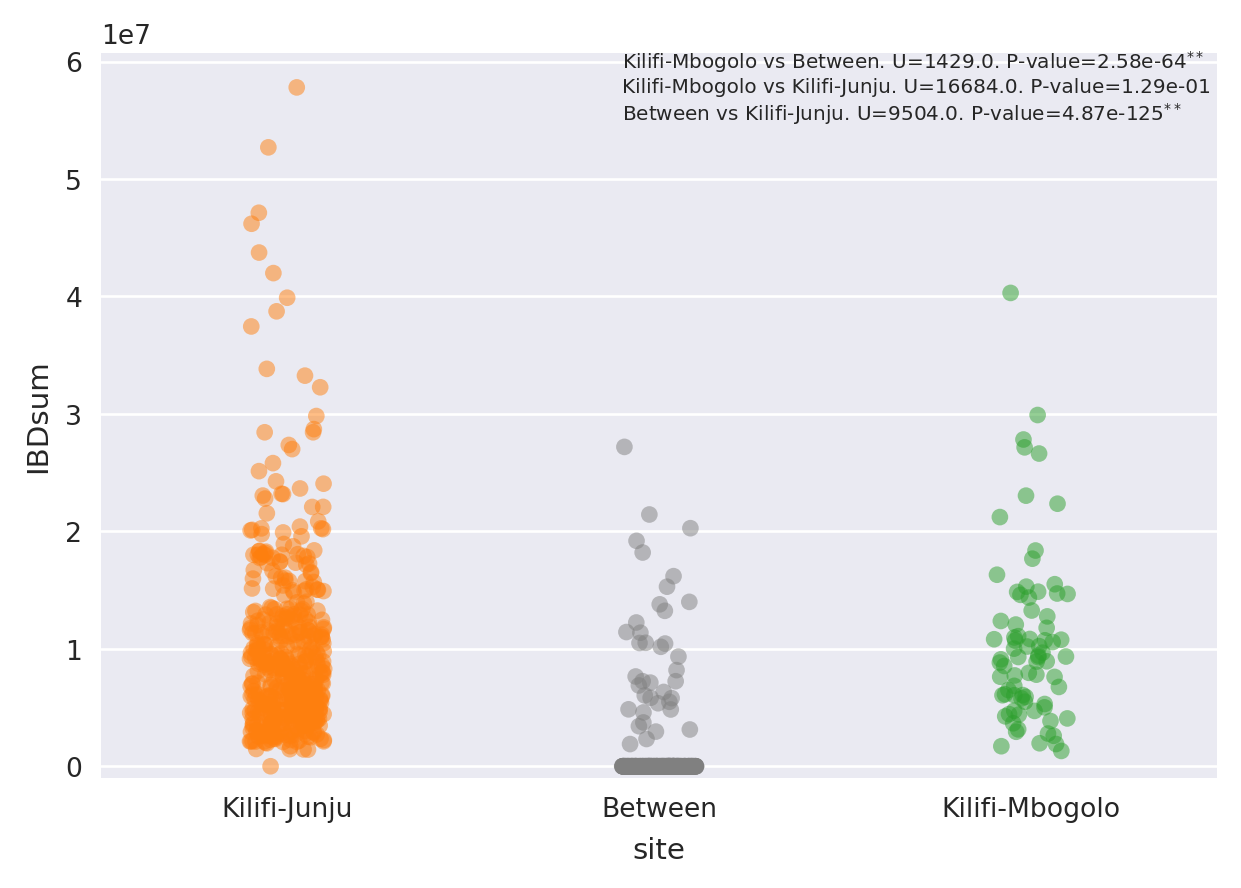

In [34]:
ax = sns.stripplot(x="site", y="IBDsum", 
                   data=all_pairs_ibd, jitter=True, 
                   palette=palette,
                   alpha=0.5)

ax.set_ylim(bottom=-1e6)
ax.text(0.9, 55000000, "\n".join(rholder), fontsize=6)

In [35]:
bins = np.linspace(0, ibd_tab.ibd_chunk_size.max(), 50)

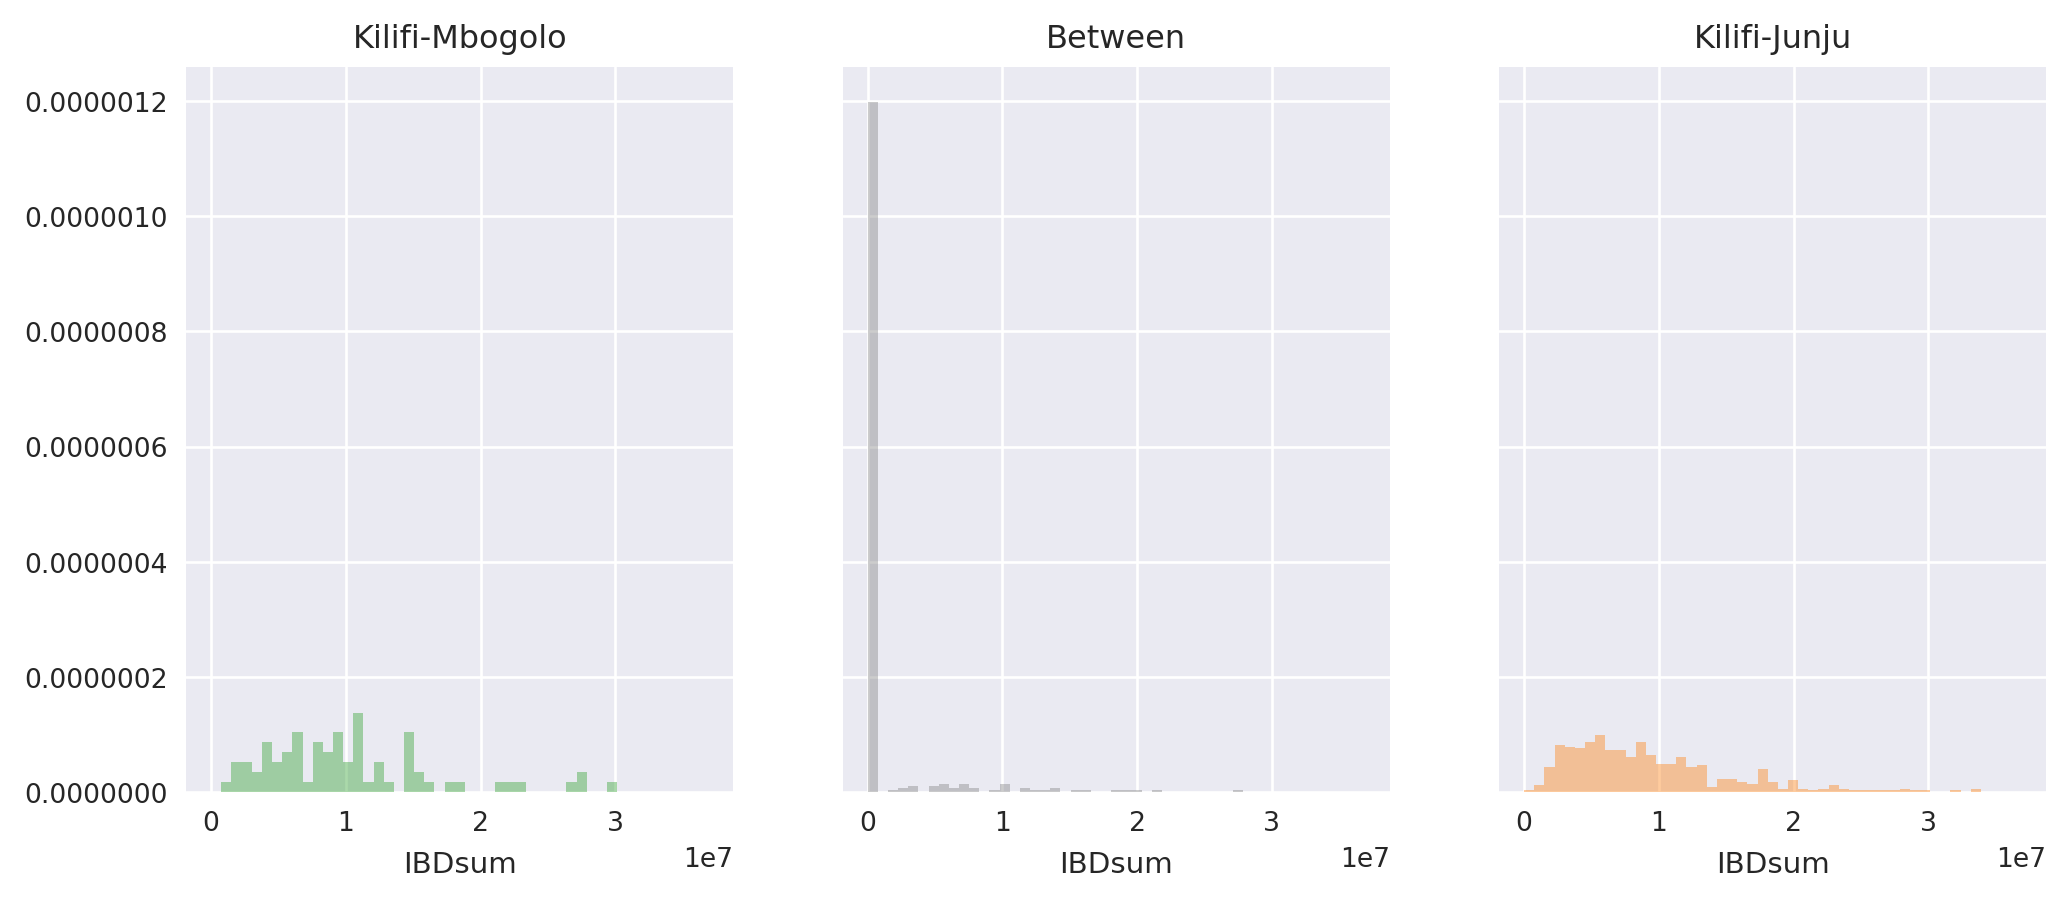

In [36]:
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True,
                         figsize=(10, 4))

for v, ax in zip(all_pairs_ibd.site.unique(), axes):
    a = all_pairs_ibd.query("site == @v").IBDsum
    sns.distplot(a, ax=ax, 
                 kde=False, 
                 norm_hist=True,
                 color=palette[v], 
                 bins=bins)
    ax.set_title(v)

## Conclusions

- More IBD within sites than between sites
- Excess of combinations with 0 IBD in between sites
- Only single Junju pair has no IBD.
- Zero Mbogolo pairs have no IBD